In [8]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA

mnist = fetch_openml("mnist_784", version=1)
X = mnist.data / 255.0
y = mnist.target.astype(int)

train_samples = 20000
test_samples = 10000

X_train_raw = X[:train_samples]
y_train = y[:train_samples]

X_test_raw = X[train_samples:train_samples + test_samples]
y_test = y[train_samples:train_samples + test_samples]

pca = PCA(n_components=50)
X_train = pca.fit_transform(X_train_raw)
X_test = pca.transform(X_test_raw)

Initialization 0
  Iteration 10	 time lapse 1.60684s	 ll change 0.05236
  Iteration 20	 time lapse 1.43019s	 ll change 0.11992
  Iteration 30	 time lapse 1.45514s	 ll change 0.00229
Initialization converged. time lapse 5.27477s	 lower bound -30.60740.
GMM Accuracy: 0.6133


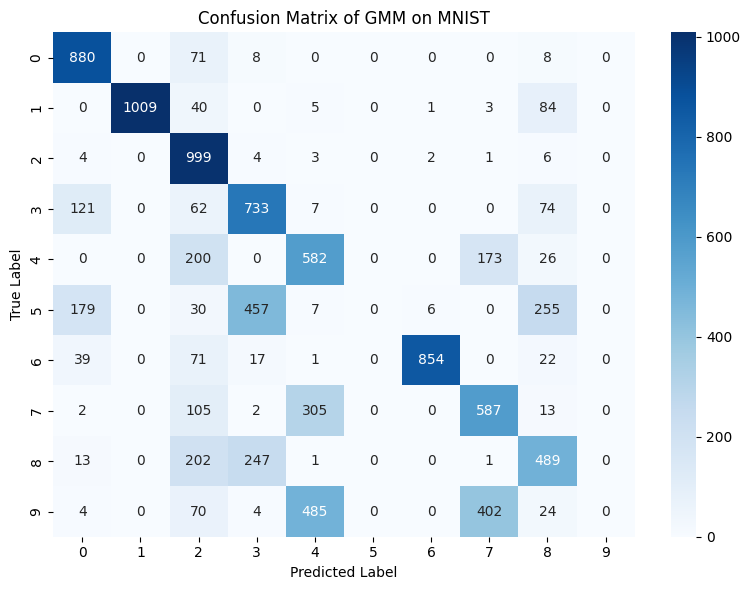

In [13]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import mode
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np

# Step 1: Fit GMM with 10 components (digits 0–9)
gmm = GaussianMixture(n_components=10, covariance_type='full', random_state=42, verbose=2)
gmm.fit(X_train)

# Step 2: Predict cluster assignments on test data
y_pred = gmm.predict(X_test)

# Step 3: Map GMM cluster labels to true digit labels using majority vote
def map_clusters_to_digits(y_true, y_pred, n_clusters):
    labels = np.zeros_like(y_pred)
    for cluster in range(n_clusters):
        mask = (y_pred == cluster)
        if np.any(mask):
            labels[mask] = mode(y_true[mask], keepdims=False).mode
    return labels

# Use the fixed mapping function
y_pred_mapped = map_clusters_to_digits(y_test, y_pred, n_clusters=10)

# Accuracy
acc = accuracy_score(y_test, y_pred_mapped)
print(f"GMM Accuracy: {acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_mapped, labels=range(10))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of GMM on MNIST')
plt.tight_layout()
plt.show()


Training GMM with 10 components...
Initialization 0
  Iteration 10	 time lapse 1.59470s	 ll change 0.05236
  Iteration 20	 time lapse 1.45227s	 ll change 0.11992
  Iteration 30	 time lapse 1.40484s	 ll change 0.00229
Initialization converged. time lapse 5.16261s	 lower bound -30.60740.
Accuracy: 0.6133
Training GMM with 20 components...
Initialization 0
  Iteration 10	 time lapse 3.04602s	 ll change 0.05656
  Iteration 20	 time lapse 2.87586s	 ll change 0.01355
  Iteration 30	 time lapse 2.96001s	 ll change 0.00468
  Iteration 40	 time lapse 2.83595s	 ll change 0.00137
Initialization converged. time lapse 13.43039s	 lower bound -23.60550.
Accuracy: 0.7312
Training GMM with 30 components...
Initialization 0
  Iteration 10	 time lapse 4.62220s	 ll change 0.06689
  Iteration 20	 time lapse 4.22010s	 ll change 0.01154
  Iteration 30	 time lapse 4.22694s	 ll change 0.00674
  Iteration 40	 time lapse 4.20368s	 ll change 0.00459
  Iteration 50	 time lapse 4.25551s	 ll change 0.00392
  Iterati

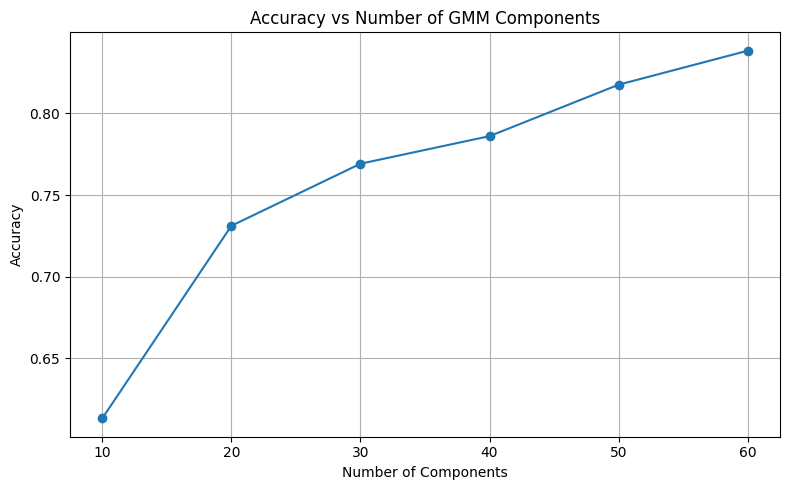

In [16]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from scipy.stats import mode
import matplotlib.pyplot as plt 
import numpy as np

def map_clusters_to_digits(y_true, y_pred, n_clusters):
    labels = np.zeros_like(y_pred)
    for cluster in range(n_clusters):
        mask = (y_pred == cluster)
        if np.any(mask):
            labels[mask] = mode(y_true[mask], keepdims=False).mode
    return labels

accuracies = []
component_range = range(10, 61, 10)

for n_components in component_range:
    print(f"Training GMM with {n_components} components...")
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42, verbose=2)
    gmm.fit(X_train)
    
    y_pred = gmm.predict(X_test)
    y_pred_mapped = map_clusters_to_digits(y_test, y_pred, n_clusters=n_components)
    
    acc = accuracy_score(y_test, y_pred_mapped)
    print(f"Accuracy: {acc:.4f}")
    accuracies.append(acc)

# Plot accuracy vs n_components
plt.figure(figsize=(8, 5))
plt.plot(component_range, accuracies, marker='o')
plt.title("Accuracy vs Number of GMM Components")
plt.xlabel("Number of Components")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


Initialization 0
  Iteration 10	 time lapse 7.67723s	 ll change 0.08349
  Iteration 20	 time lapse 7.37860s	 ll change 0.01440
  Iteration 30	 time lapse 7.18430s	 ll change 0.00998
  Iteration 40	 time lapse 7.02741s	 ll change 0.00924
  Iteration 50	 time lapse 7.05590s	 ll change 0.00234
Initialization converged. time lapse 42.64142s	 lower bound -15.59710.
GMM Accuracy with soft-label mapping: 0.8244


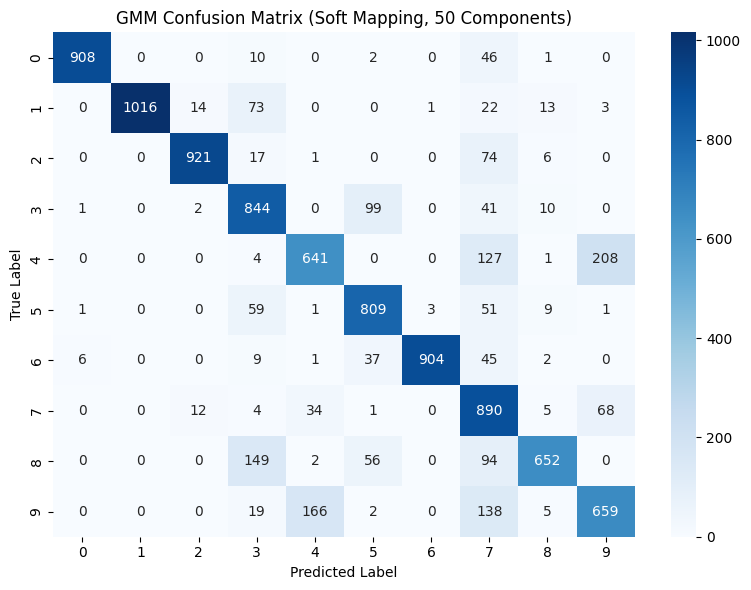

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Configurable Parameters ---
n_components = 50  # Number of GMM clusters (can be different from num_digits)
num_digits = 10    # Number of unique digit classes (for MNIST it's 10)

# Step 1: Fit GMM
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42, verbose=2)
gmm.fit(X_train)

# Step 2: Predict soft cluster assignments on test data
probs = gmm.predict_proba(X_test)  # shape: (num_samples, n_components)

# Step 3: Learn label distribution for each cluster from training data
train_clusters = gmm.predict(X_train)
label_distribution = np.zeros((n_components, num_digits))

for cluster_id in range(n_components):
    cluster_mask = (train_clusters == cluster_id)
    if np.any(cluster_mask):
        true_labels = y_train[cluster_mask]
        counts = np.bincount(true_labels, minlength=num_digits)
        label_distribution[cluster_id] = counts / counts.sum()

# Step 4: Predict digit labels using soft voting
digit_probs = probs @ label_distribution  # shape: (num_samples, num_digits)
y_pred_soft = np.argmax(digit_probs, axis=1)

# Step 5: Evaluate accuracy
acc_soft = accuracy_score(y_test, y_pred_soft)
print(f"GMM Accuracy with soft-label mapping: {acc_soft:.4f}")

# Step 6: Plot confusion matrix
cm_soft = confusion_matrix(y_test, y_pred_soft)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_soft, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(num_digits), yticklabels=range(num_digits))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'GMM Confusion Matrix (Soft Mapping, {n_components} Components)')
plt.tight_layout()
plt.show()


Ensemble GMM Accuracy: 0.9658


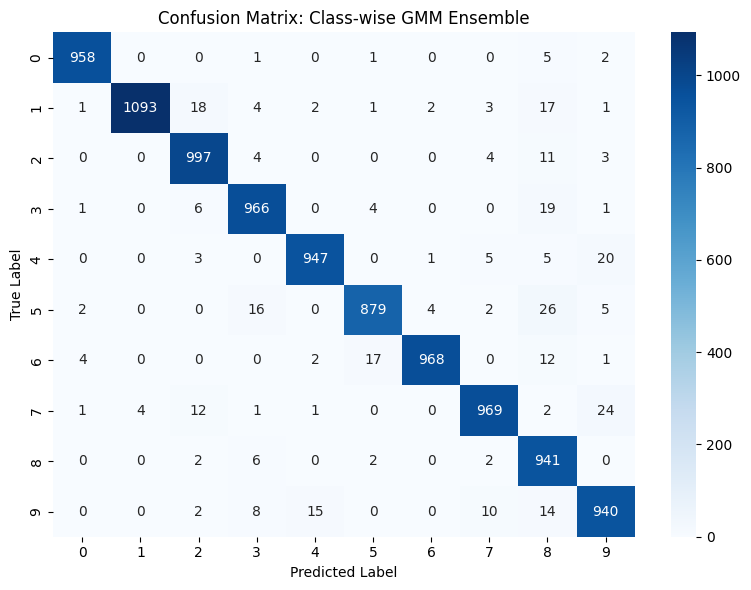

In [17]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
n_components = 5  # Number of Gaussians per class
num_classes = 10  # Digits 0 to 9

# Step 1: Train one GMM per class
gmm_models = {}
for digit in range(num_classes):
    # Extract samples of the current digit
    X_class = X_train[y_train == digit]
    
    # Train GMM for this class
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(X_class)
    
    gmm_models[digit] = gmm

# Step 2: Predict labels for test data based on maximum likelihood across class-GMMs
log_likelihoods = np.zeros((len(X_test), num_classes))  # shape: [num_samples, num_classes]

for digit, gmm in gmm_models.items():
    log_likelihoods[:, digit] = gmm.score_samples(X_test)  # log p(x | class)

# Assign label with highest log-likelihood
y_pred = np.argmax(log_likelihoods, axis=1)

# Step 3: Evaluation
acc = accuracy_score(y_test, y_pred)
print(f"Ensemble GMM Accuracy: {acc:.4f}")

# Step 4: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix: Class-wise GMM Ensemble')
plt.tight_layout()
plt.show()


In [ ]:
def generate_digits(gmm_models, pca, n_samples=5):
    fig, axs = plt.subplots(num_classes, n_samples, figsize=(n_samples, num_classes))
    fig.suptitle("Generated Digits from Class-wise GMMs (post-PCA inverse)")

    for digit in range(num_classes):
        samples, _ = gmm_models[digit].sample(n_samples)
        samples_reconstructed = pca.inverse_transform(samples)  # Back to 784-dim space
        for i in range(n_samples):
            axs[digit, i].imshow(samples_reconstructed[i].reshape(28, 28), cmap='gray')
            axs[digit, i].axis('off')
    plt.tight_layout()
    plt.show()

generate_digits(gmm_models, pca)